Antes de iniciar, certifique-se que obteve uma maquina com GPU ou TPU




Seguir os passos descritos aqui https://www.kaggle.com/general/74235




In [1]:
# ! pip install -q kaggle
# from google.colab import files
# files.upload() #aqui faz o upload do kaggle.json que voce gerou. Ver link acima.

Baixar e extrair os dados

In [2]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d kmader/food41
# !unzip food41.zip

In [3]:
# import os
# os.remove('food41.zip')

Separar em treino e teste de acordo com a sugestao do autor

In [4]:
import os
with open('dataset/meta/meta/train.txt') as trainfile:
    trainlines = trainfile.readlines()
    trainlines = [line.rstrip()+'.jpg' for line in trainlines]

with open('dataset/meta/meta/test.txt') as testfile:
    testlines = testfile.readlines()
    testlines = [line.rstrip()+'.jpg' for line in testlines]

# !mkdir train/
# !mkdir test/

#create directories
with open('dataset/meta/meta/classes.txt') as classfile:
    classlines = classfile.readlines()
    classlines = [line.rstrip() for line in classlines]

for class_ in classlines:
    try:
        os.makedirs('dataset/train/'+class_)
    except:
        pass
    try:
        os.makedirs('dataset/test/'+class_)
    except:
        pass

#move files to corresponding folder
for tl in trainlines:
    try:
        os.replace('dataset/images/'+tl, 'dataset/train/'+tl)
    except:
        pass
for tl in testlines:
    try:
        os.replace('dataset/images/'+tl, 'dataset/test/'+tl)
    except:
        pass

Limpa o que nao vai ser usado

In [5]:
#clean up
for class_ in classlines:
    try:
        os.rmdir('dataset/images/'+class_)
    except:
        pass
try:
    os.rmdir('dataset/images/')
except:
    pass

Aqui comeca de fato o modelo. O codigo abaixo e apenas uma sugestao.

In [1]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam

In [2]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen_test = ImageDataGenerator(
    rescale=1./255
    #insert only preprocessing functions
)

In [3]:
train_batches = datagen.flow_from_directory('dataset/train/', batch_size=64, class_mode = 'categorical', target_size=(224, 224))
test_batches = datagen_test.flow_from_directory('dataset/test/', batch_size=64, class_mode = 'categorical', target_size=(224, 224))

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


Esta etapa pode gerar um problema. Se o flow from directory detectar mais de 101 classes, possivelmente existem arquivos temporarios do notebook escondidos dentro da pasta. Neste caso remover com !rm -r (train ou test)/.ipynb_checkpoints/

In [6]:
import scipy

print(train_batches)
print(len(train_batches))
for each in train_batches:
    print(each[0].shape)
    print(each[1].shape)
    break

1184
(64, 224, 224, 3)
(64, 101)


Investigate the dataset. Is this a balanced dataset? What performance metrics are best suited for this type of dataset?

In [10]:
print("Folders and their corresponding number of files:")
for folder in os.listdir('dataset/train'):
    folder_path = os.path.join('dataset/train', folder)
    if os.path.isdir(folder_path):
        num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        print(f"{folder}: {num_files} files")

Folders and their corresponding number of files:
apple_pie: 750 files
baby_back_ribs: 750 files
baklava: 750 files
beef_carpaccio: 750 files
beef_tartare: 750 files
beet_salad: 750 files
beignets: 750 files
bibimbap: 750 files
bread_pudding: 750 files
breakfast_burrito: 750 files
bruschetta: 750 files
caesar_salad: 750 files
cannoli: 750 files
caprese_salad: 750 files
carrot_cake: 750 files
ceviche: 750 files
cheesecake: 750 files
cheese_plate: 750 files
chicken_curry: 750 files
chicken_quesadilla: 750 files
chicken_wings: 750 files
chocolate_cake: 750 files
chocolate_mousse: 750 files
churros: 750 files
clam_chowder: 750 files
club_sandwich: 750 files
crab_cakes: 750 files
creme_brulee: 750 files
croque_madame: 750 files
cup_cakes: 750 files
deviled_eggs: 750 files
donuts: 750 files
dumplings: 750 files
edamame: 750 files
eggs_benedict: 750 files
escargots: 750 files
falafel: 750 files
filet_mignon: 750 files
fish_and_chips: 750 files
foie_gras: 750 files
french_fries: 750 files
frenc

This dataset is balanced, and the performance metric to be used is going to be acurracy.

Develop a Convolutional Neural Network architecture

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Define the model
model = Sequential()

# Convolutional layer with 32 filters, a 3x3 kernel, 'relu' activation function, and batch normalization
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional layer with 64 filters, a 3x3 kernel, 'relu' activation function, and batch normalization
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten the input for the fully connected layers
model.add(Flatten())

# Fully connected layer with 128 neurons, 'relu' activation function, and batch normalization
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer with the number of classes and 'softmax' activation function for categorical classification
model.add(Dense(len(train_batches.class_indices), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Display the model summary
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                      

In [12]:
# import tensorflow.compat.v1 as tf 

# tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True)) 

# print(tf.add([1.0, 2.0], [3.0, 4.0])) 

In [18]:
import tensorflow as tf
# Fit the model2 to the data with augmented training data
# with tf.device('/GPU:0'):
history = model.fit(
    train_batches,
    steps_per_epoch = 75750/64,
    epochs=100,
    validation_data = test_batches, #create a validation set if needed
    validation_steps= 25250/64,
    # use_multiprocessing=True,
    workers=8,
    max_queue_size=512,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    ] 
)

Epoch 1/100
1183/1183 [==============================] - 1918s 2s/step - loss: 4.4771 - accuracy: 0.0517 - val_loss: 3.9368 - val_accuracy: 0.1066
Epoch 2/100
1183/1183 [==============================] - 245s 203ms/step - loss: 3.9315 - accuracy: 0.1080 - val_loss: 3.5825 - val_accuracy: 0.1565
Epoch 3/100
1183/1183 [==============================] - 243s 204ms/step - loss: 3.6860 - accuracy: 0.1498 - val_loss: 3.9753 - val_accuracy: 0.1234
Epoch 4/100
1183/1183 [==============================] - 244s 205ms/step - loss: 3.5494 - accuracy: 0.1717 - val_loss: 3.2898 - val_accuracy: 0.2213
Epoch 5/100
1183/1183 [==============================] - 245s 205ms/step - loss: 3.4562 - accuracy: 0.1884 - val_loss: 3.3103 - val_accuracy: 0.2075
Epoch 6/100
1183/1183 [==============================] - 245s 206ms/step - loss: 3.3968 - accuracy: 0.2019 - val_loss: 3.1452 - val_accuracy: 0.2423
Epoch 7/100
1183/1183 [==============================] - 247s 207ms/step - loss: 3.3396 - accuracy: 0.2126 -

Daqui para baixo, podem ser gerados os resultados. A variavel hist pode ser usada para plotar as curvas. Para obter as predicoes, usar model.predict(test_batches). Matrizes de confusao e metricas podem ser facilmente calculadas usando o pacote scikit-learn.

In [19]:
test_loss, test_accuracy = model.evaluate(test_batches)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

395/395 [==============================] - 325s 823ms/step - loss: 3.1452 - accuracy: 0.2423
Test Accuracy: 24.23%


In [20]:
model.save_weights('first_try.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


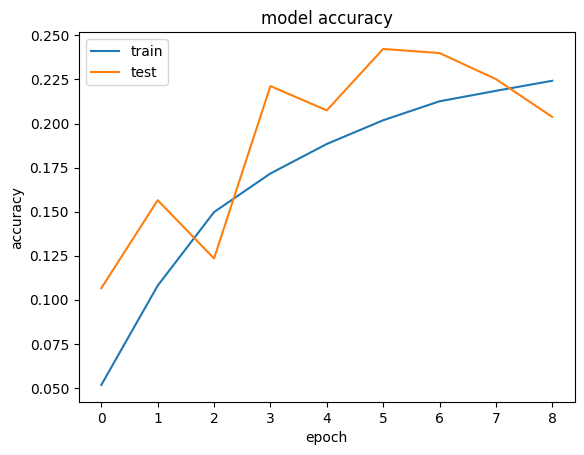

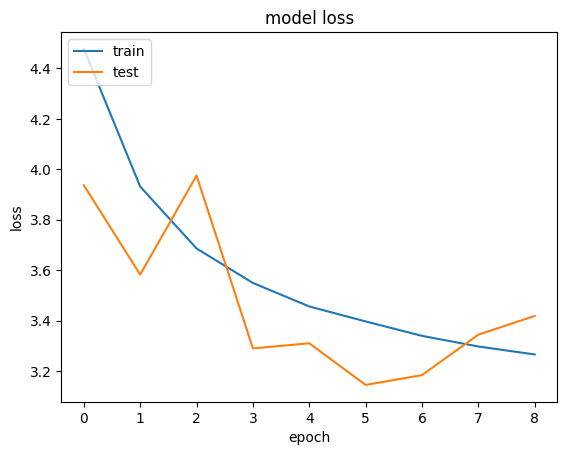

In [21]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
test_loss, test_accuracy = model.evaluate(test_batches)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

395/395 [==============================] - 54s 136ms/step - loss: 2.9444 - accuracy: 0.2836
Test Accuracy: 28.36%


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
# Define the model_2
model_2 = Sequential()

# Convolutional layer with 32 filters, a 6x6 kernel, 'relu' activation function
model_2.add(Conv2D(32, (6, 6), input_shape=(224, 224, 3), activation='relu'))
model_2.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional layer with 64 filters, a 6x6 kernel, 'relu' activation function, and batch normalization
model_2.add(Conv2D(32, (6, 6), activation='relu'))
model_2.add(MaxPool2D(pool_size=(2, 2)))
model_2.add(BatchNormalization())

# Flatten the input for the fully connected layers
model_2.add(Flatten())

# Fully connected layer with 128 neurons, 'relu' activation function, and batch normalization
model_2.add(Dense(128, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))

# Output layer with the number of classes and 'softmax' activation function for categorical classification
model_2.add(Dense(len(train_batches.class_indices), activation='softmax'))

# Compile the model_2
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model_2 summary
model_2.summary()

# Train the model_2 using RMSprop
model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Display the model_2 summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 219, 219, 32)      3488      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 104, 104, 32)      36896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 52, 52, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 52, 52, 32)       128       
 ormalization)                                                   
                                                        

In [5]:
import tensorflow as tf
# Fit the model2 to the data with augmented training data
# with tf.device('/GPU:0'):
history_2 = model_2.fit(
    train_batches,
    steps_per_epoch = 75750/64,
    epochs=100,
    validation_data = test_batches, #create a validation set if needed
    validation_steps= 25250/64,
    # use_multiprocessing=True,
    workers=8,
    max_queue_size=512,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    ] 
)


Epoch 1/100
1183/1183 [==============================] - 256s 215ms/step - loss: 4.6592 - accuracy: 0.0320 - val_loss: 4.2012 - val_accuracy: 0.0685
Epoch 2/100
1183/1183 [==============================] - 706s 596ms/step - loss: 4.2857 - accuracy: 0.0577 - val_loss: 4.0085 - val_accuracy: 0.0957
Epoch 3/100
1183/1183 [==============================] - 253s 212ms/step - loss: 4.1053 - accuracy: 0.0827 - val_loss: 3.7911 - val_accuracy: 0.1298
Epoch 4/100
1183/1183 [==============================] - 254s 213ms/step - loss: 3.9746 - accuracy: 0.0998 - val_loss: 3.6335 - val_accuracy: 0.1543
Epoch 5/100
1183/1183 [==============================] - 282s 237ms/step - loss: 3.8887 - accuracy: 0.1144 - val_loss: 3.6349 - val_accuracy: 0.1508
Epoch 6/100
1183/1183 [==============================] - 292s 246ms/step - loss: 3.8425 - accuracy: 0.1217 - val_loss: 3.6194 - val_accuracy: 0.1570
Epoch 7/100
1183/1183 [==============================] - 252s 211ms/step - loss: 3.8029 - accuracy: 0.1291

In [6]:
test_loss_2, test_accuracy_2 = model_2.evaluate(test_batches)
print(f'Test Accuracy: {test_accuracy_2 * 100:.2f}%')

395/395 [==============================] - 193s 488ms/step - loss: 3.3273 - accuracy: 0.2048
Test Accuracy: 20.48%


In [7]:
model_2.save_weights('second_try.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


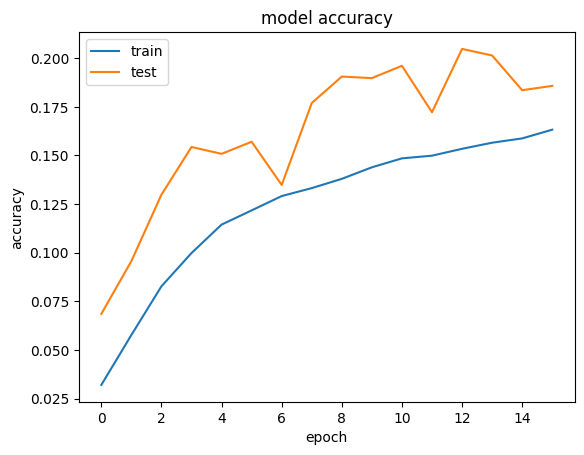

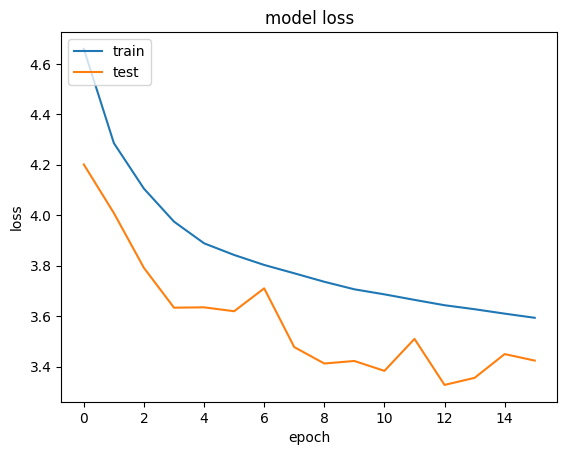

In [9]:
import matplotlib.pyplot as plt
# list all data in history_2
print(history_2.history.keys())
# summarize history_2 for accuracy
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history_2 for loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
# Define the model_3
model_3 = Sequential()

# Convolutional layer with 32 filters, a 3x3 kernel, 'relu' activation function
model_3.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model_3.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional layer with 32 filters, a 3x3 kernel, 'relu' activation function, and batch normalization
model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPool2D(pool_size=(2, 2)))
model_3.add(BatchNormalization())

# Convolutional layer with 64 filters, a 5x5 kernel, 'relu' activation function
model_3.add(Conv2D(64, (5, 5), input_shape=(224, 224, 3), activation='relu'))
model_3.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional layer with 64 filters, a 5x5 kernel, 'relu' activation function, and batch normalization
model_3.add(Conv2D(64, (5, 5), activation='relu'))
model_3.add(MaxPool2D(pool_size=(2, 2)))
model_3.add(BatchNormalization())

# Flatten the input for the fully connected layers
model_3.add(Flatten())

# Fully connected layer with 512 neurons, 'relu' activation function, and batch normalization
model_3.add(Dense(512, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))

# Output layer with the number of classes and 'softmax' activation function for categorical classification
model_3.add(Dense(len(train_batches.class_indices), activation='softmax'))

# Compile the model_3
model_3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model_3 summary
model_3.summary()

# Train the model_3 using RMSprop
model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Display the model_3 summary
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 54, 54, 32)       128       
 hNormalization)                                                 
                                                      

In [11]:
import tensorflow as tf
# Fit the model2 to the data with augmented training data
# with tf.device('/GPU:0'):
history_3 = model_3.fit(
    train_batches,
    steps_per_epoch = 75750/64,
    epochs=100,
    validation_data = test_batches, #create a validation set if needed
    validation_steps= 25250/64,
    # use_multiprocessing=True,
    workers=8,
    max_queue_size=512,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    ] 
)


Epoch 1/100
1183/1183 [==============================] - 1354s 1s/step - loss: 4.6586 - accuracy: 0.0545 - val_loss: 4.1990 - val_accuracy: 0.0955
Epoch 2/100
1183/1183 [==============================] - 275s 203ms/step - loss: 3.9378 - accuracy: 0.1143 - val_loss: 3.7914 - val_accuracy: 0.1554
Epoch 3/100
1183/1183 [==============================] - 221s 186ms/step - loss: 3.5782 - accuracy: 0.1670 - val_loss: 3.9278 - val_accuracy: 0.1606
Epoch 4/100
1183/1183 [==============================] - 222s 187ms/step - loss: 3.3387 - accuracy: 0.2109 - val_loss: 3.1873 - val_accuracy: 0.2373
Epoch 5/100
1183/1183 [==============================] - 223s 187ms/step - loss: 3.1766 - accuracy: 0.2418 - val_loss: 3.0412 - val_accuracy: 0.2638
Epoch 6/100
1183/1183 [==============================] - 224s 188ms/step - loss: 3.0473 - accuracy: 0.2689 - val_loss: 2.8028 - val_accuracy: 0.3126
Epoch 7/100
1183/1183 [==============================] - 222s 187ms/step - loss: 2.9401 - accuracy: 0.2885 -

In [12]:
test_loss_3, test_accuracy_3 = model_3.evaluate(test_batches)
print(f'Test Accuracy: {test_accuracy_3 * 100:.2f}%')

395/395 [==============================] - 801s 2s/step - loss: 2.2495 - accuracy: 0.4303
Test Accuracy: 43.03%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


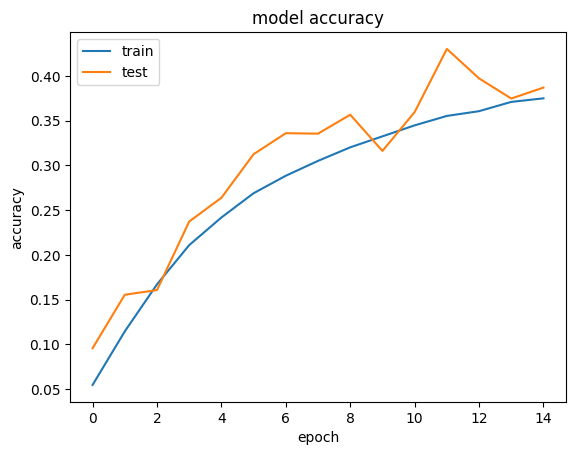

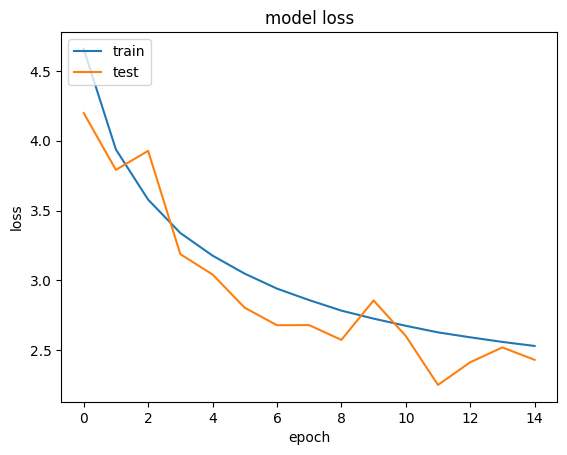

In [13]:
import matplotlib.pyplot as plt
# list all data in history_3
print(history_3.history.keys())
# summarize history_3 for accuracy
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history_3 for loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model_3.save_weights('third_try.h5')

In [16]:
from tensorflow.keras.models import load_model
#model_3 = load_model('third_try.h5')
predictions_3 = model_3.predict(test_batches)
print(predictions_3)

395/395 [==============================] - 71s 179ms/step
[[1.6816853e-02 3.2546395e-04 1.7508036e-02 ... 9.2571322e-03
  1.0261098e-04 1.3433230e-02]
 [1.8856144e-02 1.6605969e-04 1.8534005e-02 ... 4.5061328e-02
  3.4406601e-04 5.8564846e-03]
 [2.2526239e-03 1.2293293e-03 2.4930823e-03 ... 7.1771997e-06
  4.3537858e-04 2.9658334e-04]
 ...
 [5.1727407e-03 1.0571012e-03 1.4939652e-03 ... 1.7956308e-04
  1.7014343e-03 7.9708081e-03]
 [1.1372152e-06 3.5932957e-05 3.8089772e-06 ... 1.8473171e-05
  3.3295194e-03 1.6533416e-04]
 [2.9708605e-04 8.9503937e-06 6.5321365e-05 ... 1.1496950e-06
  1.9242432e-05 5.0095898e-01]]


In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn
confusion_matrix_3 = confusion_matrix(test_batches.classes, np.argmax(predictions_3, axis=1))

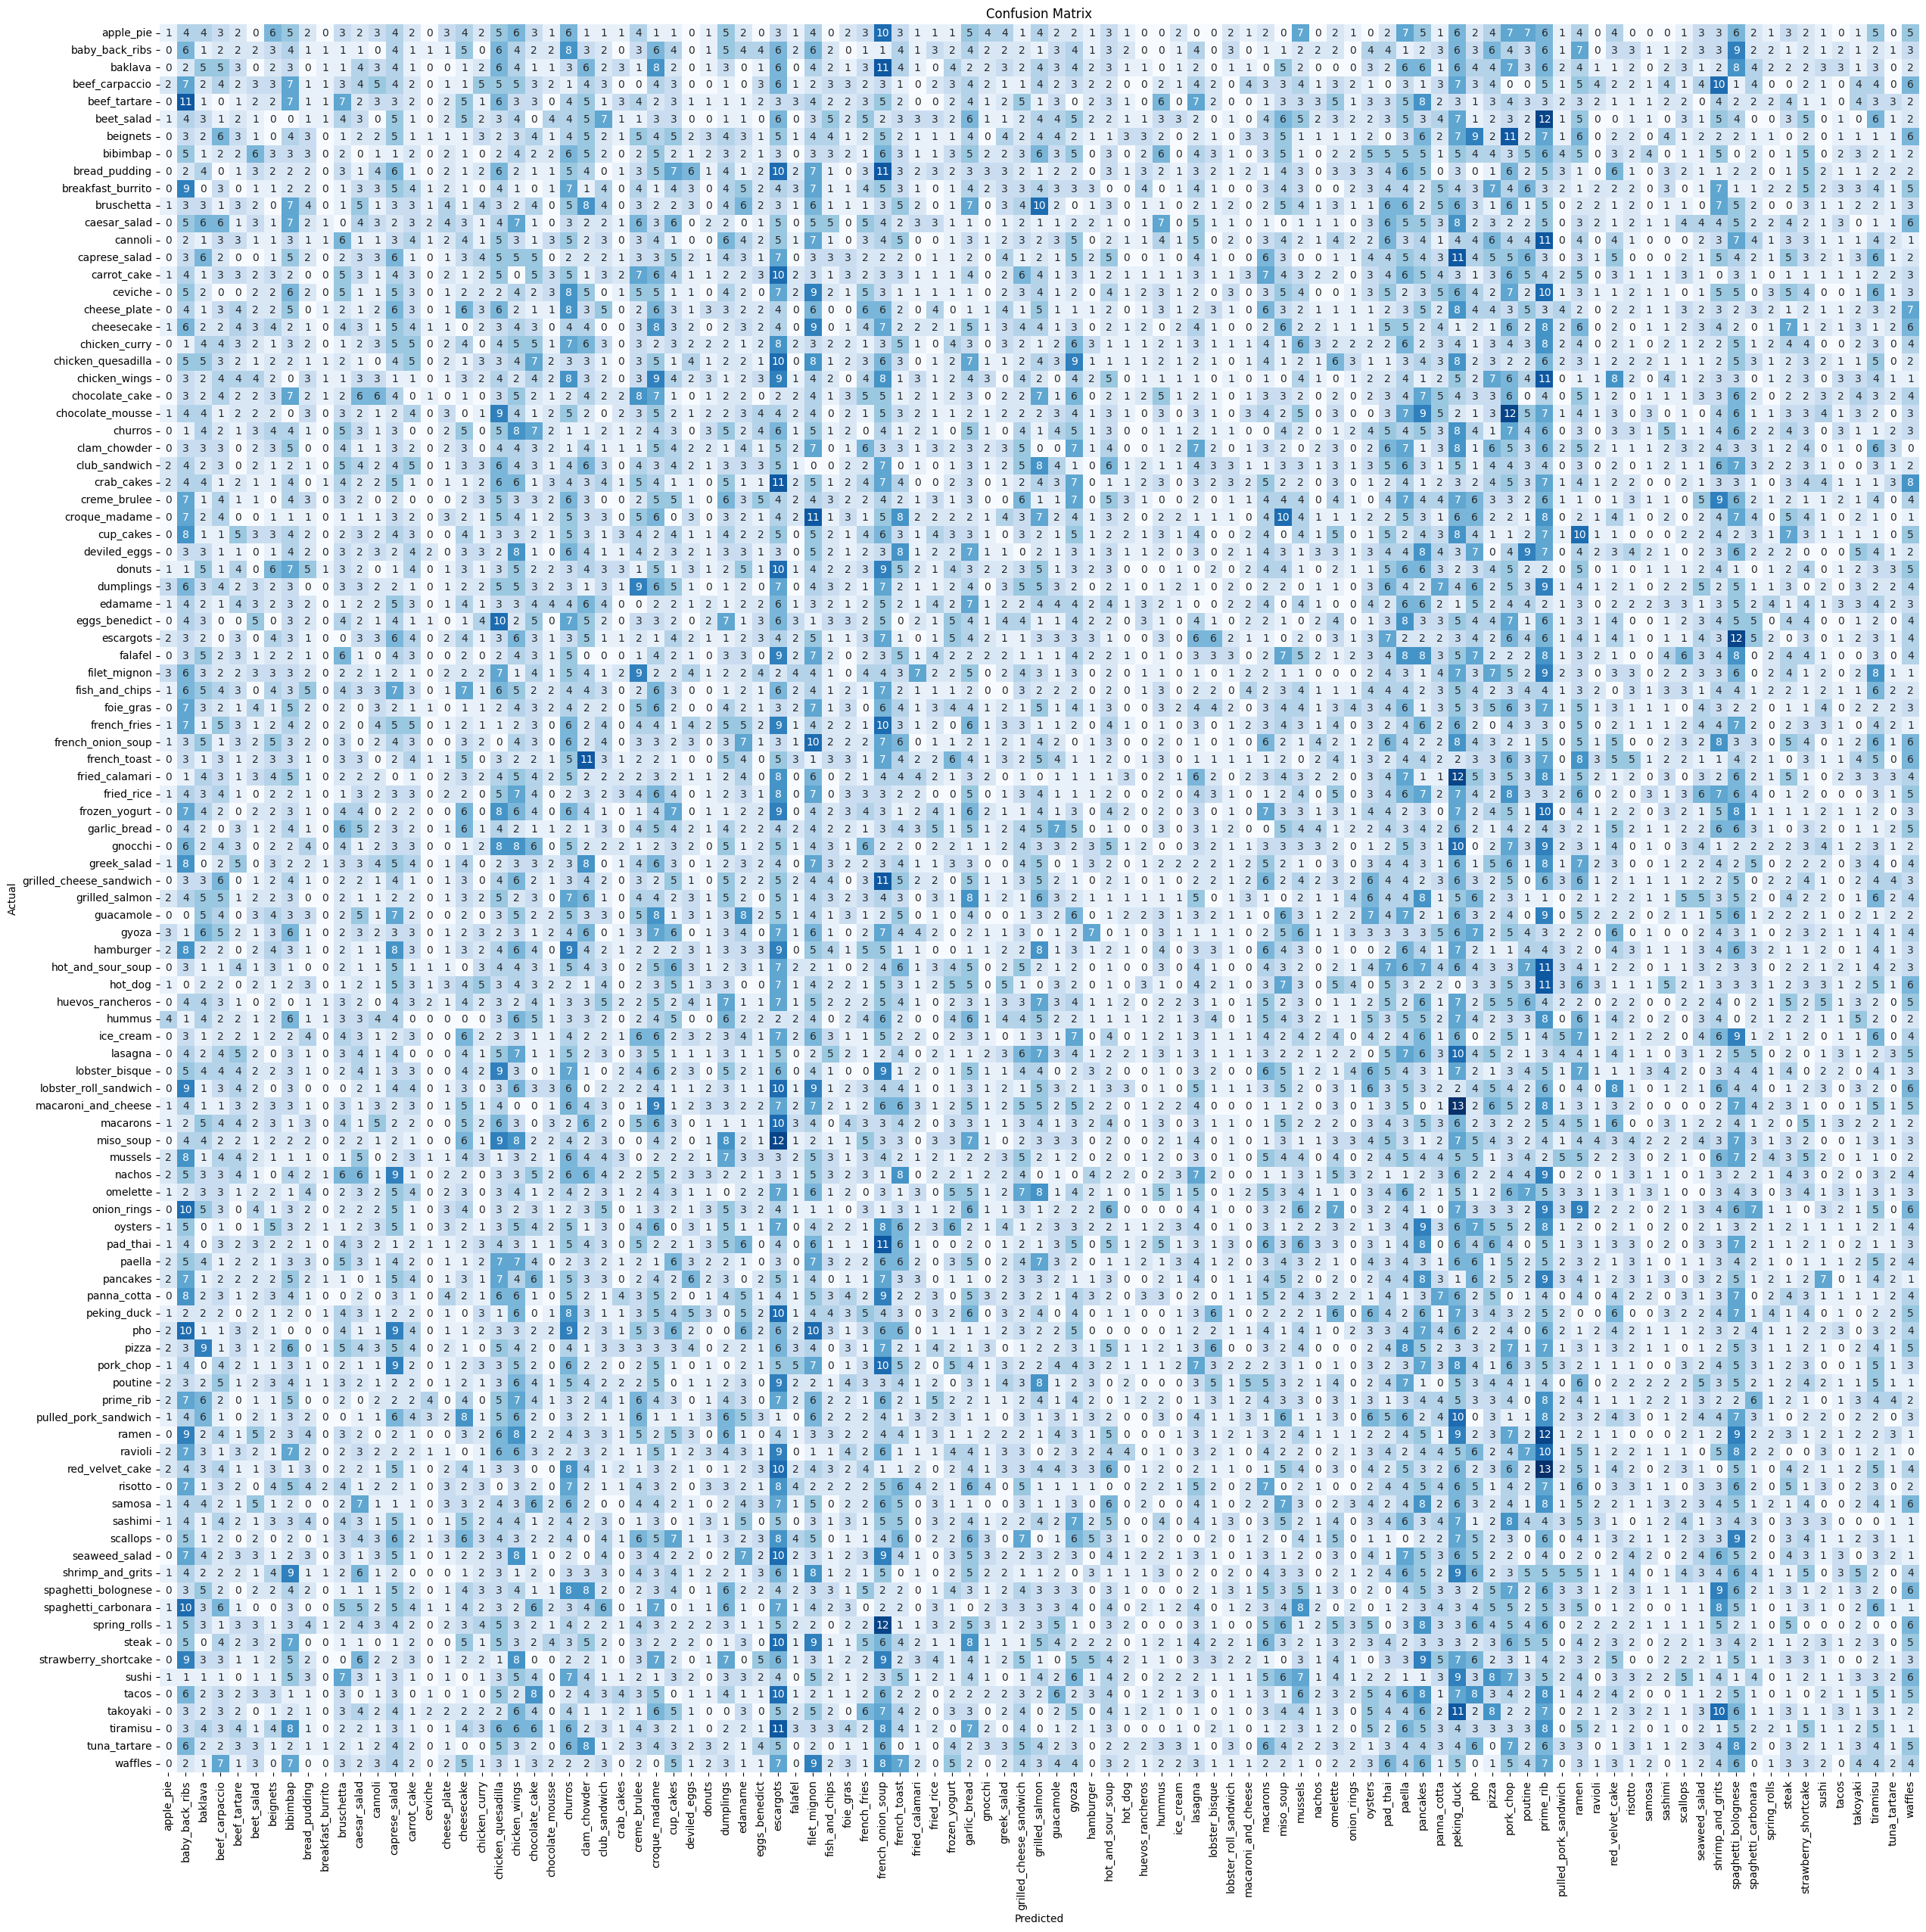

In [26]:
plt.figure(figsize=(30, 30))
seaborn.heatmap(confusion_matrix_3, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_batches.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_batches.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Feature extraction: Tentei diferentes arquiteturas, o resultado foi melhorando de acordo com o aumento da complexidade da CNN.
Inicialmente, utilizando 1 camada de 32 filtros e kernel 3x3 + 64 filtros e kernel 3x3 (Apenas 20% de acurácia)
Finalmente, utilizando 2 camadas de 32 filtros e kernel 3x3 + BatchNormalization + 2 camadas de 64 filtros e kernel 5x5
Classification: MLP com camadas de 512 e 101 neuronios .
Número de épocas: Configurei 100 épocas com early stop, a última arquitetura alcançou o pico em 14 épocas.

Nota: O número de tentativas foi limitado pelo tempo de execução, mesmo com o Colab Pro tive dificuldades durante o treinamento, com o kernel travando diversas vezes. Os próximos passos seriam treinar com uma porção menor do dataset afim de achar a arquitetura mais adequada e depois utilizar gridsearch para optimizar as camadas de classificação.